# pset 08: the cycle of twelve

# 1. solve by maximum likelihood

In [1]:
# import necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from scipy.optimize import minimize

# read in data from file
with open("w08-data.tbl.txt", "r") as infile:
    infile = infile.readlines()

# parse data, strip newline characters & split into list elements
infile = [line.strip().split() for line in infile]

# extract time and sigma values from column headers
t = [int(t[:-2]) for t in infile[0]]
sigma = [int(s[2:]) for s in infile[1][1:]]

# extract data, convert values to floats
data_tbl = [[line[0]] + [float(i) for i in line[1:]] for line in infile[3:]]

# initialize theta
theta = [1,1,1]

In [2]:
# define negative log likelihood function
def NLL(theta, t, y, sigma):
    ll = 0
    
# iterate through data points, find mu value using the function, calculate logpdf using the data, mu, and sigma at time t
    for i in range(len(y)):
    
# pass in exp(a) to ensure positive values
        mu = theta[1] + np.exp(theta[0])*np.sin(2*np.pi*(1/24)*(t[i]+(theta[2] % 24)))
        ll += norm.logpdf(y[i]-mu, loc=0, scale=sigma[i])
        
# return negative sum (negative log likelihood)
    return -ll

In [3]:
# apply the optimization function for each gene, minimizing the negative log likelihood (maximizing log likelihood)
my_params = []
for gene in data_tbl:
    y = gene[1:]
    results = minimize(NLL, theta, args=(t, y, sigma))
    
# exponentiate a to find true values
    results.x[0] = np.exp(results.x[0])
    
# apply mod 24 for phi values, we want 0 <= phi < 24
    results.x[2] = results.x[2] % 24

# append each set of parameters to a list (by gene)
    my_params.append(results.x)

In [4]:
# visualize parameters in a pandas dataframe
my_params = np.array(my_params)
pd.DataFrame(my_params, columns = ['a (tpm)', 'b (tpm)', 'phase (hr)'], index = np.array(data_tbl)[:,0])

,a (tpm),b (tpm),phase (hr)
anise,17.244435,40.172727,13.715486
kiwi,21.208743,41.515042,5.739873
carrot,34.676005,44.654609,4.158166
grape,27.715381,41.954827,20.159635
tangerine,26.241822,40.927142,15.993743
melon,27.890747,44.800175,17.599526
clementine,25.270099,44.288973,21.972217
spinach,20.334595,45.430157,11.747027
beet,21.381026,41.577989,7.543746
huckleberry,22.244469,42.485344,9.946390


# 2. compare solutions

In [5]:
# externally run moriarty's script and parse his output
moriarty = !python moriarty.py "w08-data.tbl.txt"
moriarty = [line.strip().split() for line in moriarty]
mor_params = [[float(i) for i in line[1:]] for line in moriarty[2:]]
mor_params = [[line[1]] + [line[0]] + [line[2]] for line in mor_params]

In [6]:
# define a function that will calculate my total log likelihood across all genes
def my_tot_NLL(theta, t, y, sigma):
    tot_ll = 0
    for i in range(len(theta)):
        a, b, phi = theta[i]
        tot_ll += NLL([np.log(a), b, phi], t, y[i], sigma)
    return tot_ll

In [7]:
# define a function that will calculate total log likelihood for a single sigma value (to optimize moriarty's sigma)
def mor_tot_NLL(sigma, all_theta, t, all_y):
    tot_ll = 0
    for i in range(len(all_theta)):
        theta = all_theta[i]
        y = all_y[i]
        ll = 0
        for j in range(len(y)):
            mu = theta[1] + theta[0]*np.sin(2*np.pi*(1/24)*(t[j]+(theta[2] % 24)))
            ll += norm.logpdf(y[j]-mu, loc=0, scale=sigma)
        tot_ll += -ll
    return tot_ll

In [8]:
# optimize over sigma using moriarty's parameters
data = [line[1:] for line in data_tbl]
init_sigma = 1
sigma_opt = minimize(mor_tot_NLL, init_sigma, args=(mor_params, t, data))
mor_sigma = sigma_opt.x[0]
print('optimal sigma value:', mor_sigma)

optimal sigma value: 11.44487652710344


In [9]:
# compute negative log likelihood for my parameters, moriarty's parameters using the real sigma values, 
# and again for moriarty's parameters using the optimal sigma value
my_ll = my_tot_NLL(my_params, t, data, sigma)
mor_ll = my_tot_NLL(mor_params, t, data, sigma)
mor_ll_opt = mor_tot_NLL(mor_sigma, mor_params, t, data)

print('my total negative log likelihood:', my_ll)
print("moriarty's total negative log likelihood (using real sigmas):", mor_ll)
print("moriarty's total negative log likelihood (optimized over sigma):", mor_ll_opt)

# compute likelihood ratio, ratio of exponentiated log likelihoods
print('\nlikelihood ratio (using real sigmas):', np.exp(-my_ll)/np.exp(-mor_ll))
print('likelihood ratio (using optimal sigma):', np.exp(-my_ll)/np.exp(-mor_ll_opt))

my total negative log likelihood: 317.8920121655975
moriarty's total negative log likelihood (using real sigmas): 556.3600791659463
moriarty's total negative log likelihood (optimized over sigma): 370.222118786173

likelihood ratio (using real sigmas): 3.675916252368805e+103
likelihood ratio (using optimal sigma): 5.329378219968214e+22


My optimal parameters gave a min negative log likelihood value of 317.9. I calculated Moriarty's negative log likelihood value in two different ways. For the first, I used the true sigma values given in the pset, and for the second, I ran another optimization over a single sigma value (since Moriarty's method assumes all sigmas were the same). Regardless of the method, my parameters produced the higher log likelihood value (or lowest negative log likelihood). I computed likelihood ratios comparing my likelihood to both of Moriarty's, which produced very large values in both cases (meaning that my parameters are much more likely, and that the data should fit my curves much better).

# 3. plot the fits

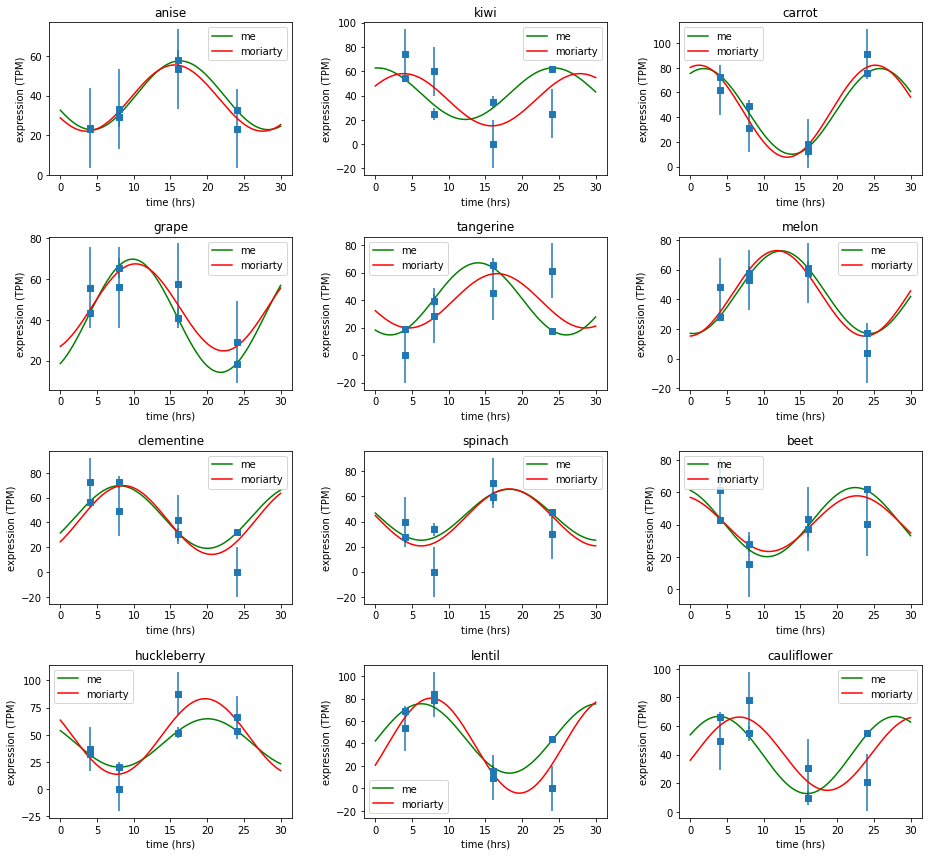

In [10]:
# set size of figure, generate x values
f = plt.figure(figsize=(13,12))
xs = np.linspace(0, 30, 200)

# add a subplot for each of the 12 genes
for i in range(12):
    ax = f.add_subplot(4, 3,i+1)

# extract mine and moriarity's parameters
    my_theta = my_params[i]
    mor_theta = mor_params[i]
    
# generates mine and moriarity's sin curves given the parameters
    my_pred = my_theta[1] + my_theta[0]*np.sin(2*np.pi*(1/24)*(xs+my_theta[2]))
    mor_pred = mor_theta[1] + mor_theta[0]*np.sin(2*np.pi*(1/24)*(xs+mor_theta[2]))
    
# plot sin curves
    plt.plot(xs, my_pred, color = 'green', label = 'me')
    plt.plot(xs, mor_pred, color = 'red', label = "moriarty")
    
# plot actual data values with an error bar to indicate the sigma/uncertainty
    plt.errorbar(t, data_tbl[i][1:], sigma, fmt="s")
    
# set titles, show legend
    plt.title(data_tbl[i][0])
    plt.xlabel('time (hrs)')
    plt.ylabel('expression (TPM)')
    plt.legend()

# adjust spacing of figure / subplots
f.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)

We can see the difference between assuming a standard sigma value and using different sigma values for each set of data. The graphs show that the green curve (my parameters) produce a better fit for the data. This is particularly evident in cases where the two data points at a certain time point are very spread out with very different uncertainties (one large, one small); while Moriarty's curve passes neatly in the middle of these points, my curve is skewed towards the point with less uncertainty (smaller sigma).